# Change input state space to tensor (survey data + path), and NN model to convolutional neural network

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import os # for creating directories
import pydot

In [2]:
state_size = 10*10 #10x10 matrix data, do np.reshape([100])

In [3]:
a1 = np.reshape(np.reshape(np.arange(100), [10,10]), [100])

In [4]:
action_size = 4

In [5]:
batch_size = 10

In [6]:
output_dir = 'model_output/ToyProblem/'


In [7]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000) # double-ended queue; acts like list, but elements can be added/removed from either end
        self.gamma = 1 #0.95 # decay or discount rate: enables agent to take into account future actions in addition to the immediate ones, but discounted at this rate
        self.epsilon = 0.99 # exploration rate: how much to act randomly; more initially than later due to epsilon decay
        self.epsilon_decay = 0.995 # decrease number of random explorations as the agent's performance (hopefully) improves over time
        self.epsilon_min = 0.01 # minimum amount of random exploration permitted
        self.learning_rate = 0.001 # rate at which NN adjusts models parameters via SGD to reduce cost 
        self.model = self._build_model() # private method 
    
    def _build_model(self):
        # neural net to approximate Q-value function:
        model = models.Sequential()
        model.add(layers.Conv2D(10, (3, 3), activation='relu', input_shape=(10, 10, 2)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(16, (3, 3), activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(4))

        
        #model = Sequential()
        #model.add(Dense(5, input_dim=self.state_size, activation='relu')) # 1st hidden layer; states as input
        #model.add(Dense(24, activation='relu')) #add move layers, for CNN
        #model.add(Dense(self.action_size, activation='linear')) # 2 actions, so 2 output neurons: 0 and 1 (L/R)
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # list of previous experiences, enabling re-training later

    def act(self, state):
        if np.random.rand() <= self.epsilon: # if acting randomly, take random action
            return random.randrange(self.action_size)
        act_values = self.model.predict(state) # if not acting randomly, predict reward value based on current state
        return np.argmax(act_values[0]) # pick the action that will give the highest reward (i.e., go left or right?)

    def replay(self, batch_size): # method that trains NN with experiences sampled from memory
        minibatch = random.sample(self.memory, batch_size) # sample a minibatch from memory
        for state, action, reward, next_state, done in minibatch: # extract data for each minibatch sample
            target = reward # if done (boolean whether game ended or not, i.e., whether final state or not), then target = reward
            if not done: # if not done, then predict future discounted reward
                target = (reward + self.gamma * # (target) = reward + (discount rate gamma) * 
                          np.amax(self.model.predict(next_state)[0])) # (maximum target Q based on future action a')
            target_f = self.model.predict(state) # approximately map current state to future discounted reward
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0) # single epoch of training with x=state, y=target_f; fit decreases loss btwn target_f and y_hat
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [9]:
agent = DQNAgent(state_size, action_size) # initialise agent 

2022-11-13 00:50:56.857265: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 00:50:56.880012: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/home/aremorov/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
agent

In [11]:
start_state = np.zeros([10,10])

In [12]:
state = start_state # reset state at start of each new episode of the game
state = np.reshape(state, [1, state_size])


In [13]:
state.T.shape

(100, 1)

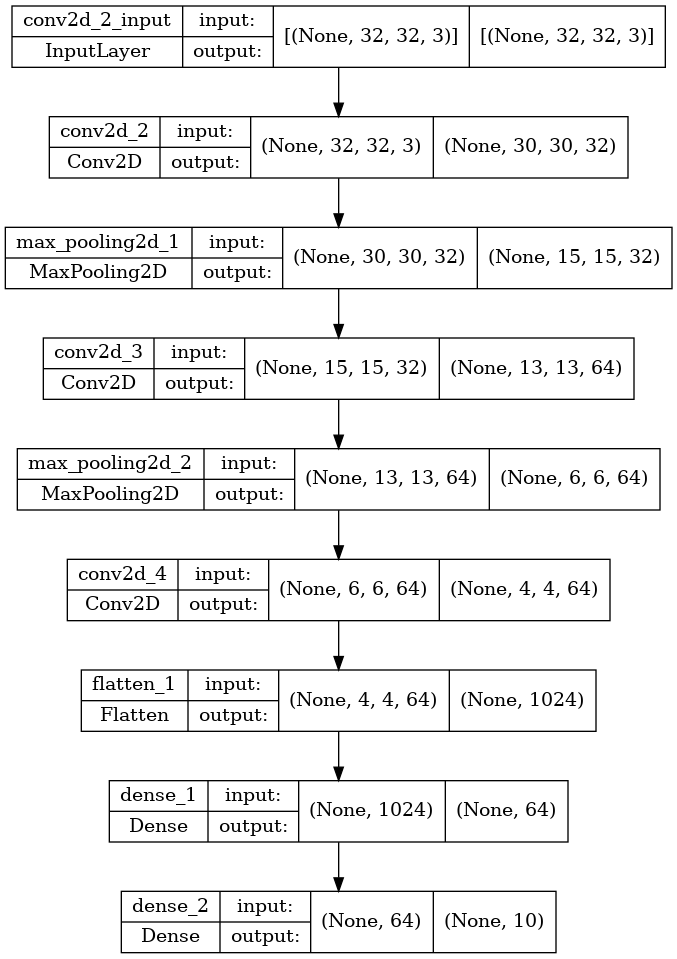

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
state.shape

(1, 100)

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu', input_shape=(10, 10, 2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(4))
#tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
action = agent.act(state) + 1
action

2

# Toy problem

In [19]:
#setting up actions:

def movef(action, position):
    moved = False
    newposition = position #make the new position the current position, so position does not change if move is invalid
    if action == 1 and position[1] != 9: #right
        newposition = [position[0], position[1]+1]
        moved == True
    if action == 2 and position[0] != 0: #up
        newposition = [position[0]-1, position[1]]
        moved == True
    if action == 3 and position[1] != 0: #left
        newposition = [position[0], position[1]-1]
        moved == True
    if action == 4 and position[0] != 9: #down
        newposition = [position[0] + 1, position[1]]
        moved == True
    return newposition

In [20]:
def RMSreward(real, fit):
    real = np.array(real)
    fit = np.array(fit)
    RMS = np.sqrt(np.average((real - fit)**2))
    reward = 1/(RMS + 0.01)
    return reward

In [21]:
#setting up subsurface model:

M = np.zeros([10,10]) #generate grid of zeros
tlc = [random.randint(0,5),random.randint(0,5)] #top left corner
M[tlc[0]:tlc[0] + 5, tlc[1]:tlc[1] + 5] = 1
M

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0.]])

In [22]:
#now for the reward, we do ground truthing, by fitting a 5x5 square to the
#state data, and then determining the misfit

def fitstate(S): #takes in the state
    fit = False

    while(not fit):
        #generate possible fit model:
        fM = np.zeros([10,10]) #fit Model
        ftlc = [random.randint(0,5),random.randint(0,5)] #fit top left corner
        fM[ftlc[0]:ftlc[0] + 5, ftlc[1]:ftlc[1] + 5] = 1

        fit = True #make fit true, but false if fit does not agree with survey
        for i in range(len(fM)):
            for j in range(len(fM[i])):
                if(S[i,j] != 0 and fM[i,j] * 2 - 1 != S[i,j]):
                    fit = False
    return fM

In [23]:
start_state = np.zeros([10,10,2]) #original state


In [24]:
sp = [0,0] #start at top left corner
p = sp 

state = start_state + 0 # reset state at start of each new episode of the game


In [25]:
state.shape

(10, 10, 2)

In [26]:
move  = 1
p = movef(move, p)
state[p[0], p[1], 0] = M[p[0], p[1]] * 2 - 1
state[p[0], p[1], 1] = 1 #1st move
#state = np.reshape(state2D, [1, state_size])
state[:,:,0]

array([[ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [27]:
state[:,:,1]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [28]:
state.shape

(10, 10, 2)

In [29]:
agent = DQNAgent(state_size, action_size) # initialise agent 

/home/aremorov/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
reward_list = []

In [ ]:
#need to figure out how to make this learn faster...implement CNN
n_episodes = 1000  # n games we want agent to play (default 1001)
for e in range(n_episodes): # iterate over new episodes of the game
    state = np.zeros([10,10,2]) # reset state at start of each new episode of the game
    sp = [5,5]
    p = sp
    
    M = np.zeros([10,10]) #generate random model
    tlc = [5*random.randint(0,1),5*random.randint(0,1)]
    M[tlc[0]:tlc[0] + 5, tlc[1]:tlc[1] + 5] = 1
    
    print(e)
    timesteps = 20
    for time in range(timesteps):  # time represents a frame of the game; goal is to keep pole upright as long as possible up to range, e.g., 500 or 5000 timesteps
        action = agent.act(state) # action is 0,1,2,3
        p = movef(action+1, p) #make action 1,2,3,4
        current_state = state + 0 #fix the current state, then change state to next state
        state[p[0], p[1],0] = M[p[0], p[1]] * 2 - 1 #survey measurement
        state[p[0], p[1],1] = time #path
        next_state = state + 0
        reward = 0
        if(time == timesteps - 1):
            reward = RMSreward(fitstate(state[:,:,0]), M) 
            reward_list.append(reward)
            print(reward)
        
        agent.remember(current_state, action, reward, next_state, False) # remember the previous timestep's state, actions, reward, etc.        
        state = next_state+0 # set "current state" for upcoming iteration to the current next state        
        
    if len(agent.memory) > batch_size:
        agent.replay(batch_size) # train the agent by replaying the experiences of the episode
    if e % 50 == 0:
        agent.save(output_dir + "weights_" + '{:04d}'.format(e) + ".hdf5")         

In [ ]:
e

In [ ]:
state2D

In [ ]:
state2D[5,4]

In [ ]:
reward_list[4]

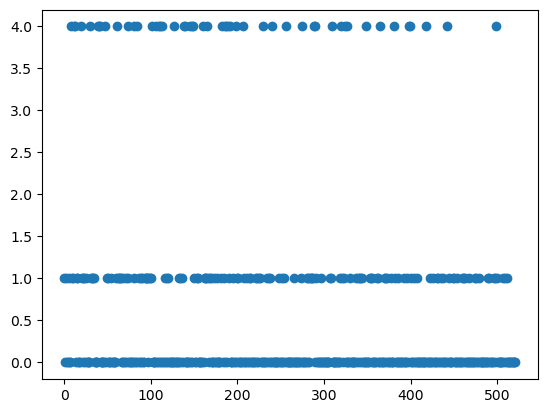

In [133]:
plt.scatter(np.arange(len(reward_list)), reward_list)

In [ ]:
state2D_list[4]